Image Colorization
======
We show image colorization as an example of an image-to-image application of CNNs. For practicality, we only experiment on CIFAR. A lot of approaches can be taken to improve the results over the straight-forward implementation in this notebook:

* [*Let there be Color!*](http://hi.cs.waseda.ac.jp/~iizuka/projects/colorization/en/), Iizuka et al., 2016
* [*Colorful Image Colorization*](http://richzhang.github.io/colorization/), Zhang et al. 2016
* [*Learning Representations for Automatic Colorization*](https://arxiv.org/abs/1603.06668), Larsson et al., 2016
* [*Real-Time User-Guided Image Colorization with Learned Deep Priors*](https://richzhang.github.io/ideepcolor/), Zhang et al. 2017


In [134]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from skimage import color
import random
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from sklearn.metrics import accuracy_score
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm


Parameter Settings
-------------------


In [135]:
#torch.manual_seed(42)
batch_size = 256
use_gpu = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


CIFAR Data Loading
-------------------

The CIFAR dataset contains 60000 32x32 colour images, split into 50000 training images and 10000 test images. Each image is labeled as one of either 10 (CIFAR10) or 100 (CIFAR100) classes, but we are not using the labels here.

In [136]:


#train_dataset = EncoderDataset(indices = train_indices,img_dir = home)
#val_dataset = EncoderDataset(indices = test_indices,img_dir = home)
#train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=True)
#val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [137]:
# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])

train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Color Regressor Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [138]:
import torch.nn.functional as F

class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # out: 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # out: 64 x 8 x 8
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # out: 128 x 4 x 4
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # out: 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.conv_stack = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1),  # out: 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1),  # out: 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # out: 64 x 8 x 8
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # out: 128 x 4 x 4
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # out: 32 x 16 x 16
            #nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1),  # out: 2 x 32 x 32
        )

    def forward(self, input):
        x = self.encoder(input)
        x = self.conv_stack(x)
        x = self.decoder(x)

        return x

model = ColorNet()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 699650


Train Color Regressor
--------


In [139]:
def train_one_epoch(train_dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
    running_loss = 0.

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    with torch.set_grad_enabled(is_train):
        for _, data in enumerate(tqdm(train_dataloader)):
            # Every data instance is an input + label pair
            
            lab_batch, _ = data
            lab_batch = lab_batch.to(device)

            predicted_ab_batch = model(lab_batch[:, 0:1, :, :])

            loss = loss_fn(predicted_ab_batch, lab_batch[:, 1:3, :, :])
            if is_train:
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

            # Gather data and report
            running_loss += loss.item()

    return running_loss/len(train_dataloader)

In [140]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.3f}")
      val_loss = train_one_epoch(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.3f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t, 'train_history': train_history, 'val_history': val_history}
        torch.save(save_dict, model_name + '_best_model.pth')
        
    # save training history for plotting purposes
      train_history["loss"].append(train_loss)

      val_history["loss"].append(val_loss)
      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t, 'train_history': train_history, 'val_history': val_history}
      torch.save(save_dict, model_name + '_latest_model.pth')
      
  print("Finished")
  return train_history, val_history

In [142]:
class WeightedSmoothL1Loss(nn.Module):
    def __init__(self, weight_factor=1):
        super(WeightedSmoothL1Loss, self).__init__()
        self.weight_factor = weight_factor

    def forward(self, input, target):
        log_loss = nn.SmoothL1Loss()(input, target)
        color_counts_a = torch.histc(target[:, 0, :, :], bins=20, min=-110, max=110)
        color_counts_b = torch.histc(target[:, 1, :, :], bins=20, min=-110, max=110)
        rarity_weights_a = 1 / (color_counts_a + 1e-6)
        rarity_weights_b = 1 / (color_counts_b + 1e-6)
        rarity_weights_a = rarity_weights_a / torch.sum(rarity_weights_a)
        rarity_weights_b = rarity_weights_b / torch.sum(rarity_weights_b)
        color_rarity = rarity_weights_a * rarity_weights_b
        weighted_loss = torch.sum(log_loss * color_rarity)
        weighted_loss *= self.weight_factor
        return weighted_loss

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_fn = WeightedSmoothL1Loss()


# set to training mode
epochs = 50
model.train()
train_history, val_history = train(model, 'colorization_homebrew', epochs, train_dataloader, val_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 196/196 [00:29<00:00,  6.54it/s]


Train loss: 1.136


100%|██████████| 40/40 [00:04<00:00,  9.08it/s]


Val loss: 1.084

Epoch 2


 11%|█         | 22/196 [00:03<00:27,  6.25it/s]


KeyboardInterrupt: 

Plot Training Curves
--------------------

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(train_history['loss'], label='train')
plt.plot(val_history['loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


Alternatively: Load Pre-Trained Color Regressor
-----------------------------

In [ ]:

model = ColorNet()

state_dict = torch.load('colorization_homebrew_weight_log_bin20.pth')
model.load_state_dict(state_dict['model'])
model.to(device)
print('done')

done


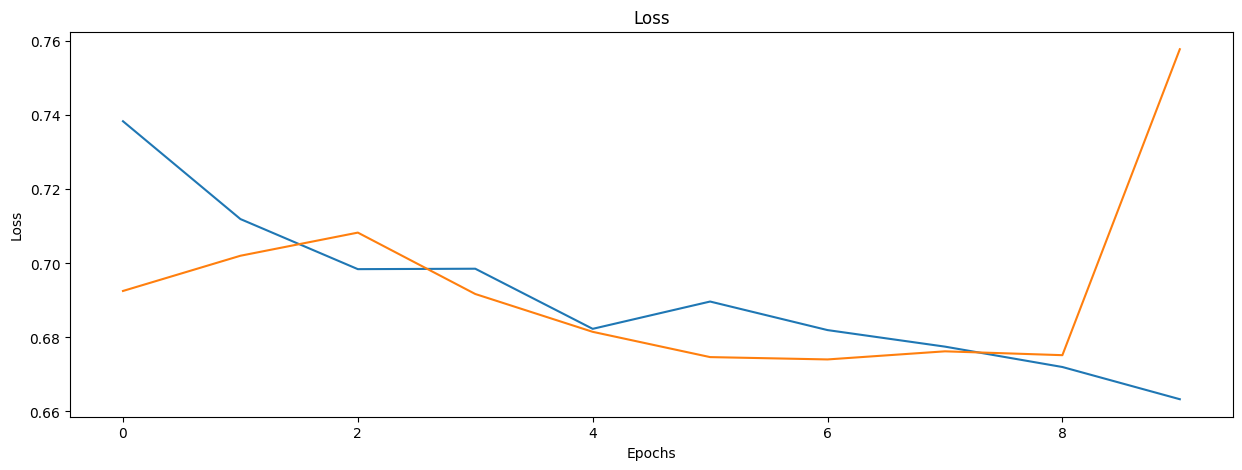

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(state_dict['train_history']['loss'], label='train')
plt.plot(state_dict['val_history']['loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate on the Test Set
----------------------------

In [143]:
# set to evaluation mode
model.eval()

test_loss_avg, num_batches = 0, 0
for lab_batch, _ in val_dataloader:

    with torch.no_grad():

        lab_batch = lab_batch.to(device)

        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])

        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 173.037905


Show Random Re-Colored Images from the Test Set
-------------------------------------------------
Since our network is relatively simple and small, it still makes a lot of errors, but things like sky, water and background vegetation usually get a plausible color. Correctly coloring details on various objects would require a network with more parameters and for really good results at higher resolutions, some additional tricks need to be applied, as described in the papers linked at the beginning.

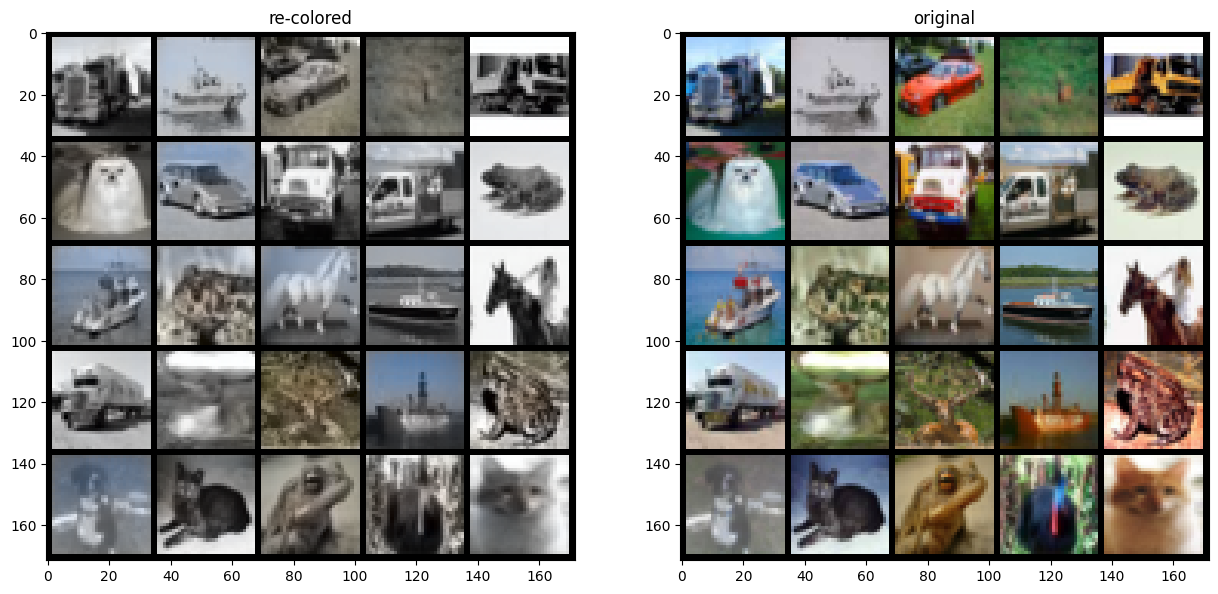

In [144]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(val_dataset), 25, replace=False)
    lab_batch = torch.stack([val_dataset[i][0] for i in image_inds])
    lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)

    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()
